In [1]:
import sys, os, re, copy
import dill as pickle # this serializes all the functions inside the quantification dict
import numpy as np
import scipy as sp
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as tck
from matplotlib.gridspec import GridSpec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

## On plate acid hydrolysis based quantification of total amino acids and nucleotides
We have observed that my previous amino acid consumption data resulted in a lot higher accumulated concentration per cell than what was found when quantifying amino acids in cells scraped off a well.
It was noted that after application of 80% MeOH, cell scraping and drying, the wells had a layer of unknown material which could be extracellular protein (and other “sticky” molecules).
Maybe these explain the discrepancy between amino acid consumption and accumulation in scraped cells.
This could be investigated by quantifying total amino acids including the extracellular protein.
To this end two solutions were proposed:
Trypsinization and then acid hydrolysis.
On plate acid hydrolysis.

Using trypsin will contaminate the lysate with amino acids from the trypsin; however, this could be subtracted by running samples with only trypsin in parallel.
The math of trypsin to cells protein is here approximated:  
200 pg protein per cell, 1e6 cells = 200 ng protein  
10 uL 0.25% trypsin = 25 ng protein (add saline with 0.1 mM EDTA to increase volume)

However, how long does it take for trypsin to fully liberate the whole extracellular matrix? Is it even possible?
Some of the doubts are hard to address, thus I went with the second solution.

First some tests concluded that standard TC plates can be sealed with microamp optical adhesive film and tolerate 6 M HCl for at least 24h.
With that knowledge here is the experimental design:  
1. Two 12W plates seeded in parallel (DMEM dia. FBS)
2. At 40-90% confluency harvest by washing four times with saline
3. Count one plate
4. On the other plate add 1 mL 6M HCl to 5 wells, seal the plate and perform acid hydrolysis at 90C in incubator for 20h
5. Move hydrolysate to 2 mL tubes then wash the well thrice with 1 mL water and collect it in the same tube
6. Dry the hydrolysate
7. Add 0.5 mL 6M HCl to each tube and incubate another 48h at 90C, then dry
8. Reconstitute in 0.5 mL 6M HCl and aliquot 2 tubes with 10k cells and 2 tubes with 40k cells and dry.
9. Reconstitute the two 10k tubes with 1 mL water, move to a fresh tube, dry and reconstitute these with 40 uL SE+CAAv2 and run standard LCMS
  * Water reconstitution is an attempt to get rid of the plastic/glue soluble in HCl
10. Using uracil as a control (should be in the same range regardless of scraping or on plate hydrolysis)



#### Limitations to this type of quantification
While LCMS and isotopic internal standards are really good for quantification, there are some important limitations related to undercounting of modified amino acids and nucleosides/nucleobases.
Some abundance amino acid modifiations like phosphorylation, acetylation and glycosylation are cleaved under acid hydrolysis but others like methylation are not.
The same is true for nucleobases were methylation would be expected to cause an underestimate of certain bases.

**Additionally, acid hydrolysis can result in breakdown of purines and thus purine quantities could be underestimated.**
For proper purine quantification acid hydrolysis at 80C for 2 hours should have been performed but this would have resulted in incomplete release of cell material.


In [2]:
# Convert amino acid full name to three letter name:
AAcode = {
    'Alanine': 'Ala',
    'Arginine': 'Arg',
    'Asparagine': 'Asn',
    'Aspartate': 'Asp+Asn',
    'Glutamate': 'Gln+Glu',
    'Glutamine': 'Gln',
    'Glycine': 'Gly',
    'Isoleucine': 'Ile',
    'Leucine': 'Leu',
    'Lysine': 'Lys',
    'Methionine': 'Met',
    'Phenylalanine': 'Phe',
    'Proline': 'Pro',
    'Serine': 'Ser',
    'Threonine': 'Thr',
    'Tryptophan': 'Trp',
    'Tyrosine': 'Tyr',
    'Valine': 'Val'
}
# Convert nucleobase full name to three letter abreviations:
NB_code = {'Adenine': 'Ade', 'Guanine': 'Gua', 'Uracil': 'Ura', 'Thymine': 'Thy', 'Cytosine': 'Cyt'}

In [3]:
def impute_conc(piece_wise_fit_metab, response_ratio):
    '''
    This function imputes the concentration from a response ratio.
    '''
    response_ratio_range = np.array(list(piece_wise_fit_metab.keys()))
    mask_range = [response_ratio >= min_v and response_ratio <= max_v for max_v, min_v in response_ratio_range]
    k = tuple(response_ratio_range[mask_range][0])
    conc = piece_wise_fit_metab[k](response_ratio)
    estimator = 'intrapolation'
    if 0 in k:
        estimator = 'extrapolation under'
    elif np.inf in k:
        estimator = 'extrapolation over'
    return(conc, estimator)

### Perform quantification and export data

In [4]:
# List of nucleobases with quantification data:
NB_quant_list = ['Guanine pos', 'Adenine pos', 'Uracil neg', 'Cytosine pos', 'Thymine neg', 'Hypoxanthine pos', 'Xanthine neg', 'Guanosine pos', 'Adenosine pos', 'Uridine neg', 'Cytidine pos', 'Deoxyuridine neg']
# List of amino acids with quantification data:
AA_quant_list = ['Aspartate neg', 'Glutamate neg', 'Arginine pos', 'Tyrosine pos', 'Serine neg', 'Proline pos', 'Threonine neg', 'Lysine pos', 'Leucine pos', 'Valine pos', 'Phenylalanine pos', 'Isoleucine pos', 'Alanine pos']
# All compounds to quantify:
quant_set = set(NB_quant_list + AA_quant_list)

In [5]:
### Read quantification function ###
dict_pickle_fnam = 'input/AA-nucleoside_quant-dict.pickle'
with open(dict_pickle_fnam, 'rb') as handle:
    piece_wise_fit_AA_nucs = pickle.load(handle)
dict_pickle_fnam = 'input/nucleobase_quant-dict.pickle'
with open(dict_pickle_fnam, 'rb') as handle:
    piece_wise_fit_nucb = pickle.load(handle)
# Merge the two quantitation dictionaries:
piece_wise_fit_quant = {**piece_wise_fit_AA_nucs, **piece_wise_fit_nucb}

### Read measurements ###
### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('input/143B-H1299_Nuc_on-plate-prot_quant.xlsx', sheet_name=None)
annotation_df = pd.read_excel('input/annotations.xlsx')
metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k])
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Area'] / metab_dict_mes[k]['ISTD Response']
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response Ratio'].fillna(0).replace(np.inf, 0)
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Flag Details', 'Filename', 'Type', 'RT', 'Sample ID'], axis=1)

### Impute concentration and add to metabolite dataframe ###
rr_mes = dict() # for plotting 
imp_conc_mes = dict() # for plotting
for metab in metab_names_mes[:]:
    # Remove 15N from name:
    metab_split = metab.split()
    if len(metab_split) == 4:
        metab_no_iso = ' '.join([metab_split[0], metab_split[1], metab_split[-1]])
    elif len(metab_split) == 3:
        metab_no_iso = ' '.join([metab_split[0], metab_split[-1]])
    elif len(metab_split) == 2:
        metab_no_iso = metab
    else:
        raise Exception('{} not recognized metabolite name format'.format(metab))
    # Assign imputed concentration:
    if metab_no_iso in piece_wise_fit_quant:
        conc_list = list()
        estimator_list = list()
        for rr in metab_dict_mes[metab]['Response Ratio'].values:
            conc, estimator = impute_conc(piece_wise_fit_quant[metab_no_iso], rr)
            conc_list.append(conc)
            estimator_list.append(estimator)
        metab_dict_mes[metab]['imputed_sample_conc'] = conc_list
        metab_dict_mes[metab]['imputed_sample_estimator'] = estimator_list

        # Extract data for plotting:
        if metab_no_iso in rr_mes:
            rr_mes[metab_no_iso].extend(list(metab_dict_mes[metab]['Response Ratio'].values))
            imp_conc_mes[metab_no_iso].extend(list(metab_dict_mes[metab]['imputed_sample_conc'].values))
        else:
            rr_mes[metab_no_iso] = list(metab_dict_mes[metab]['Response Ratio'].values)
            imp_conc_mes[metab_no_iso] = list(metab_dict_mes[metab]['imputed_sample_conc'].values)

In [6]:
### Extract all metabolites for quantification ###
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'Formula', 'Response Ratio', 'Area', 'ISTD Response', 'imputed_sample_conc'], axis=1)
for metab in metab_names_mes:
    if metab in quant_set:
        assert(metab_dict_mes[metab]['Sample_name'].equals(df['Sample_name']))
        df[metab] = metab_dict_mes[metab]['imputed_sample_conc']

# Take the mean of the two technical (pipetting) replicates:
df_mean = df.groupby(['cell_line', 'well']).mean(numeric_only=True).reset_index()

### Calculate the total cell concentration ###
df_mean_cell_conc = copy.deepcopy(df_mean)
df_mean_cell_conc.loc[:, list(quant_set)] = df_mean_cell_conc.loc[:, list(quant_set)].mul(df_mean_cell_conc['solvent_vol'] / (df_mean_cell_conc['dilution'] * df_mean_cell_conc['cell_vol']), axis=0)

def sum_nucl(df_inp):
    ### Sum all the purine/pyrimidine species ###
    guanine_list = ['Guanine pos', 'Xanthine neg', 'Guanosine pos']
    adenine_list = ['Adenine pos', 'Hypoxanthine pos', 'Adenosine pos']
    uracil_list = ['Uracil neg', 'Uridine neg', 'Deoxyuridine neg']
    thymine_list = ['Thymine neg']
    cytosine_list = ['Cytosine pos', 'Cytidine pos']

    df_inp['Guanine'] = df_inp.loc[:, guanine_list].sum(axis=1)
    df_inp = df_inp.drop(guanine_list, axis=1)
    df_inp['Adenine'] = df_inp.loc[:, adenine_list].sum(axis=1)
    df_inp = df_inp.drop(adenine_list, axis=1)
    df_inp['Purines'] = df_inp.loc[:, ['Adenine', 'Guanine']].sum(axis=1)
    df_inp['Uracil'] = df_inp.loc[:, uracil_list].sum(axis=1)
    df_inp = df_inp.drop(uracil_list, axis=1)
    df_inp['Thymine'] = df_inp.loc[:, thymine_list].sum(axis=1)
    df_inp = df_inp.drop(thymine_list, axis=1)
    df_inp['Cytosine'] = df_inp.loc[:, cytosine_list].sum(axis=1)
    df_inp = df_inp.drop(cytosine_list, axis=1)
    df_inp['Pyrimidines'] = df_inp.loc[:, ['Uracil', 'Thymine', 'Cytosine']].sum(axis=1)
    return(df_inp)
df_mean_cell_conc = sum_nucl(copy.deepcopy(df_mean_cell_conc))

# Dump the data:
df_mean_print = df_mean_cell_conc.drop(['dilution', 'cell_vol', 'solvent_vol', 'cell_numb', 'replicate'], axis=1)
# Rename to remove pos/neg:
rename_dict = {nam: nam.split()[0] for nam in df_mean_print.columns.values}
df_mean_print = df_mean_print.rename(rename_dict, axis=1)
# Write to Excel file:
df_mean_print.to_excel('output/conc.xlsx')

In [7]:
df_mean_print

,cell_line,well,Alanine,Arginine,Aspartate,Glutamate,Isoleucine,Leucine,Lysine,Phenylalanine,...,Threonine,Tyrosine,Valine,Guanine,Adenine,Purines,Uracil,Thymine,Cytosine,Pyrimidines
0,143B,1,103418.221817,61471.719161,122022.222373,205990.793714,56233.506163,109894.877009,93019.014377,43520.204289,...,75849.832336,28836.920491,81772.319345,16892.948975,6435.339587,23328.288562,13254.802114,6310.164331,18748.267127,38313.233572
1,143B,2,101448.288966,61089.456059,118559.381793,199752.194054,56530.332405,105308.742243,90812.766578,43092.289727,...,72482.261178,29104.341887,80441.278501,16817.629320,6521.319423,23338.948742,13173.107565,6325.019967,18947.166853,38445.294385
2,143B,3,100980.051748,59323.058883,119470.493322,199098.342196,55797.207560,104404.346657,89523.954478,42551.820113,...,72004.152884,28915.307845,79813.249524,16816.448894,6781.539682,23597.988576,12831.914945,6200.871867,19214.104390,38246.891202
3,143B,4,101149.295787,60366.975769,118001.646205,199537.693882,55209.500030,104129.148046,90119.718595,42468.810180,...,72348.855095,29178.204113,78649.141345,16838.324126,7193.620917,24031.945043,12809.847564,6139.745931,18674.806567,37624.400062
4,143B,5,102970.267609,60972.651116,121115.084714,203722.166105,54424.808766,105040.445125,90559.372080,43223.181939,...,74444.473981,30242.483671,78985.974421,17013.384816,7941.967810,24955.352626,13040.915131,6335.327692,18891.222388,38267.465211
5,H1299,1,85998.819941,51795.454953,113607.261796,189444.624634,51145.829776,94974.125963,79497.408071,39567.442750,...,65196.318103,25917.859979,66544.530305,12674.943250,4212.762420,16887.705669,11725.438862,3972.303103,14535.098649,30232.840613
6,H1299,2,83491.591379,50194.642950,108696.684391,180882.569469,49023.581506,91873.273469,76142.360114,38195.291765,...,63039.464310,24924.474480,64242.361758,11732.788411,4376.405046,16109.193457,11102.213783,3714.466828,13420.481246,28237.161857
7,H1299,3,83391.531901,51389.360998,108313.105996,180857.523976,48807.111197,90552.672846,77545.792043,38006.633353,...,62113.504049,25284.450821,63951.577444,11749.639805,4564.974566,16314.614371,11134.328722,3806.234460,13712.897696,28653.460879
8,H1299,4,84083.363570,52131.188701,111271.812782,185217.926288,49112.931814,93341.851527,78843.710784,38706.318687,...,64414.488791,25763.365796,64803.925482,12276.700985,5196.555383,17473.256367,11737.335394,3886.933007,14162.405632,29786.674032
9,H1299,5,87412.302986,52548.799206,116921.854755,194151.699312,51201.254540,97453.091448,79746.048227,40754.693966,...,67756.241957,27857.012620,66754.324301,12759.176483,5543.721406,18302.897888,12192.444560,4001.535556,14369.248165,30563.228281


### Plot quantification data

#### Plot cell composition

In [8]:
# Dataframe for individual compound abundance plotting:
df_plot_abu = copy.deepcopy(df_mean_print)
df_plot_abu = df_plot_abu.rename(columns=AAcode)
df_plot_abu = df_plot_abu.rename(columns=NB_code)
df_plot_abu = df_plot_abu.drop(['Purines', 'Pyrimidines'], axis=1)

# Sort according to most abundance in 143B:
df_plot_abu_mean = df_plot_abu.groupby(['cell_line']).mean().reset_index()
util_cols = df_plot_abu.columns.values[:2]
comp_cols = df_plot_abu.columns.values[2:]
sort_mask = df_plot_abu_mean.loc[0, comp_cols].sort_values(ascending=False).index.values
sort_mask = np.concatenate([util_cols, sort_mask])
df_plot_abu_sort = df_plot_abu.loc[:, sort_mask]
# Convert to mM:
df_plot_abu_sort.loc[:, comp_cols] = df_plot_abu_sort.loc[:, comp_cols]/1000

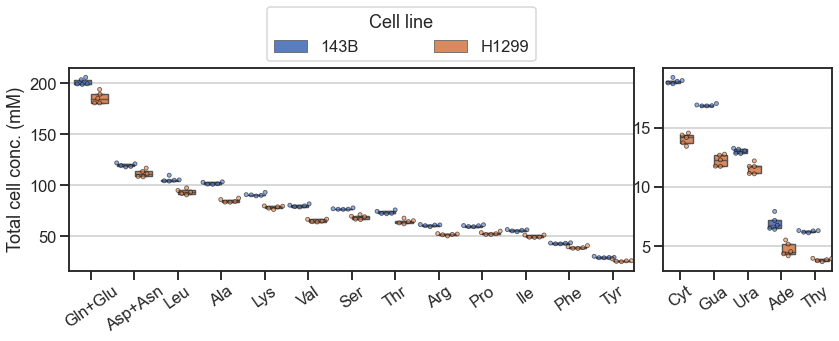

In [9]:
# Then flatten for plotting:
df_abu_flat = pd.melt(df_plot_abu_sort, id_vars=['cell_line', 'well']).rename(columns={'variable': 'Compound', 'value': 'Concentration'})

# Create plot grid:
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(8, 8)
ax1 = fig.add_subplot(gs[1:8, 0:6])
#ax2 = fig.add_subplot(gs[1:8,6:8], sharey=ax1)
ax2 = fig.add_subplot(gs[1:8, 6:8])
ax3 = fig.add_subplot(gs[0, 2:5])

# Plot the amino acids:
inclusion_list = set(AAcode.values())
mask = [v in inclusion_list for v in df_abu_flat['Compound'].values]
g1 = sns.boxplot(ax=ax1, y='Concentration', x='Compound', hue='cell_line', data=df_abu_flat[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g1 = sns.swarmplot(ax=ax1, y='Concentration', x='Compound', hue='cell_line', data=df_abu_flat[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Total cell conc. (mM)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=35)

# Plot individual nucleobases:
inclusion_list = set(NB_code.values())
mask = [v in inclusion_list for v in df_abu_flat['Compound'].values]
g2 = sns.boxplot(ax=ax2, y='Concentration', x='Compound', hue='cell_line', data=df_abu_flat[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g2 = sns.swarmplot(ax=ax2, y='Concentration', x='Compound', hue='cell_line', data=df_abu_flat[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g2.grid(True, axis='y')
#g2.set_yscale('log')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=35);
#g2.set(yticklabels=[]);

# Add legend above:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['143B', 'H1299']
title = 'Cell line'
g2.legend_.remove()
ax3.axis('off')
ax3.legend(handles, labels, title=title, bbox_to_anchor=(0,0,1,1), loc="lower left", mode="expand", borderaxespad=0, ncol=2);

# Spacing and print:
fig.tight_layout()
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig('output/cell_composition.pdf')

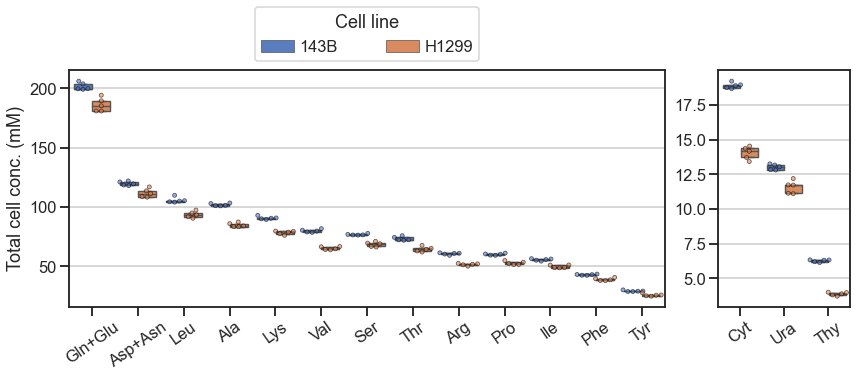

In [69]:
# Then flatten for plotting:
df_abu_flat = pd.melt(df_plot_abu_sort, id_vars=['cell_line', 'well']).rename(columns={'variable': 'Compound', 'value': 'Concentration'})

# Create plot grid:
fig = plt.figure(figsize=(13, 5))
gs = GridSpec(8, 10)
ax1 = fig.add_subplot(gs[1:8, 0:7])
#ax2 = fig.add_subplot(gs[1:8,6:8], sharey=ax1)
ax2 = fig.add_subplot(gs[1:8, 7:9])
ax3 = fig.add_subplot(gs[0, 2:5])

# Plot the amino acids:
inclusion_list = set(AAcode.values())
mask = [v in inclusion_list for v in df_abu_flat['Compound'].values]
g1 = sns.boxplot(ax=ax1, y='Concentration', x='Compound', hue='cell_line', data=df_abu_flat[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g1 = sns.swarmplot(ax=ax1, y='Concentration', x='Compound', hue='cell_line', data=df_abu_flat[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Total cell conc. (mM)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=35)

# Plot individual nucleobases:
inclusion_list = set(NB_code.values()) - set(['Ade', 'Gua'])
mask = [v in inclusion_list for v in df_abu_flat['Compound'].values]
g2 = sns.boxplot(ax=ax2, y='Concentration', x='Compound', hue='cell_line', data=df_abu_flat[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g2 = sns.swarmplot(ax=ax2, y='Concentration', x='Compound', hue='cell_line', data=df_abu_flat[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g2.grid(True, axis='y')
#g2.set_yscale('log')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=35);
#g2.set(yticklabels=[]);

# Add legend above:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['143B', 'H1299']
title = 'Cell line'
g2.legend_.remove()
ax3.axis('off')
ax3.legend(handles, labels, title=title, bbox_to_anchor=(0, 0, 1, 1), loc="lower center", mode="expand", borderaxespad=0, ncol=2, handletextpad=0.3);

# Spacing and print:
#fig.tight_layout(pad=0., w_pad=1.3, h_pad=1.0)
gs.tight_layout(fig, pad=0, w_pad=0.5, h_pad=0.5)
#fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig('output/cell_composition-no-pur.pdf', bbox_inches='tight')

In [10]:
# Read predictions and merged with measurements:
pred_df = pd.read_excel('input/cell_composition_prediction.xlsx')
pred_df['Aspartate'] = pred_df['Aspartate'] + pred_df['Asparagine']
pred_df = pred_df.drop('Asparagine', axis=1)
pred_df = pred_df.rename(columns={'Glutamate + Glutamine': 'Glutamate'})
pred_df = pred_df.rename(columns=AAcode)
pred_df = pred_df.rename(columns=NB_code)
sele_cols = pred_df.columns[1:]
pred_df.loc[:, sele_cols] = pred_df.loc[:, sele_cols]/1000
pred_df_flat = pd.melt(pred_df, id_vars=['cell_line']).rename(columns={'variable': 'Compound', 'value': 'Concentration'})
df_abu_flat_pred = df_abu_flat.merge(pred_df_flat, left_on=['cell_line', 'Compound'], right_on=['cell_line', 'Compound'], suffixes=['_mes', '_pred'])
df_abu_flat_pred['mes/pred'] = df_abu_flat_pred['Concentration_mes'] / df_abu_flat_pred['Concentration_pred']

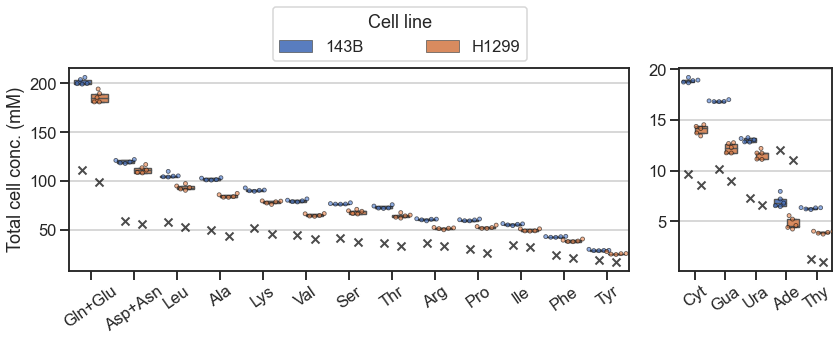

In [11]:
### Add the predictions to above plot ###
# Create plot grid:
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(8, 8)
ax1 = fig.add_subplot(gs[1:8, 0:6])
#ax2 = fig.add_subplot(gs[1:8,6:8], sharey=ax1)
ax2 = fig.add_subplot(gs[1:8, 6:8])
ax3 = fig.add_subplot(gs[0, 2:5])

# Plot the amino acids:
inclusion_list = set(AAcode.values())
mask = [v in inclusion_list for v in df_abu_flat_pred['Compound'].values]
# Add prediction, as a single cross:
one_rep_mask = (df_abu_flat_pred['well'] == 1)
g1 = sns.swarmplot(ax=ax1, y='Concentration_pred', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask&one_rep_mask], linewidth=2, alpha=0.7, dodge=True, marker='x', palette=['black', 'black'], s=8, legend=False)
# Then add the measured data:
g1 = sns.boxplot(ax=ax1, y='Concentration_mes', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g1 = sns.swarmplot(ax=ax1, y='Concentration_mes', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Total cell conc. (mM)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=35)

# Plot individual nucleobases:
inclusion_list = set(NB_code.values())
mask = [v in inclusion_list for v in df_abu_flat['Compound'].values]
# Add prediction:
one_rep_mask = (df_abu_flat_pred['well'] == 1)
g2 = sns.swarmplot(ax=ax2, y='Concentration_pred', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask&one_rep_mask], linewidth=2, alpha=0.7, dodge=True, marker='x', palette=['black', 'black'], s=8, legend=False)
# Then measurements:
g2 = sns.boxplot(ax=ax2, y='Concentration_mes', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g2 = sns.swarmplot(ax=ax2, y='Concentration_mes', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g2.grid(True, axis='y')
#g2.set_yscale('log')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=35);
#g2.set(yticklabels=[]);

# Add legend above:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['143B', 'H1299']
title = 'Cell line'
g2.legend_.remove()
ax3.axis('off')
ax3.legend(handles, labels, title=title, bbox_to_anchor=(0,0,1,1), loc="lower left", mode="expand", borderaxespad=0, ncol=2);

# Spacing and print:
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)
fig.savefig('output/cell_composition_w_predictions.pdf')

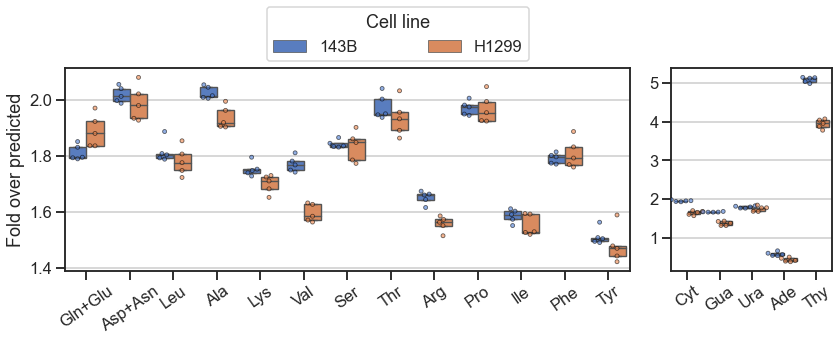

In [12]:
### Add the predictions to above plot ###
# Create plot grid:
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(8, 8)
ax1 = fig.add_subplot(gs[1:8, 0:6])
#ax2 = fig.add_subplot(gs[1:8,6:8], sharey=ax1)
ax2 = fig.add_subplot(gs[1:8, 6:8])
ax3 = fig.add_subplot(gs[0, 2:5])

# Plot the amino acids:
inclusion_list = set(AAcode.values())
mask = [v in inclusion_list for v in df_abu_flat_pred['Compound'].values]
# Then add the measured data:
g1 = sns.boxplot(ax=ax1, y='mes/pred', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g1 = sns.swarmplot(ax=ax1, y='mes/pred', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Fold over predicted');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=35)

# Plot individual nucleobases:
inclusion_list = set(NB_code.values())
mask = [v in inclusion_list for v in df_abu_flat['Compound'].values]
# Then measurements:
g2 = sns.boxplot(ax=ax2, y='mes/pred', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g2 = sns.swarmplot(ax=ax2, y='mes/pred', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g2.grid(True, axis='y')
#g2.set_yscale('log')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=35);
#g2.set(yticklabels=[]);

# Add legend above:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['143B', 'H1299']
title = 'Cell line'
g2.legend_.remove()
ax3.axis('off')
ax3.legend(handles, labels, title=title, bbox_to_anchor=(0,0,1,1), loc="lower left", mode="expand", borderaxespad=0, ncol=2);

# Spacing and print:
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)
fig.savefig('output/cell_composition_fold-predictions.pdf')

#### Plot aspartate fates

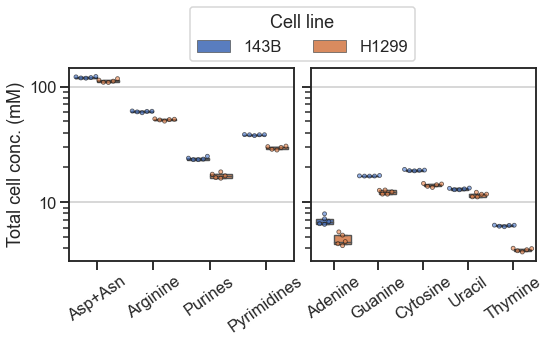

In [13]:
# Extract Asp and its fates: 
df_mean_asp = df_mean_print.loc[:, ['cell_line', 'well', 'Aspartate', 'Arginine', 'Adenine', 'Guanine', 'Cytosine', 'Uracil', 'Thymine', 'Purines', 'Pyrimidines']]
# Convert to mM:
df_mean_asp.loc[:, ['Aspartate', 'Arginine', 'Adenine', 'Guanine', 'Cytosine', 'Uracil', 'Thymine', 'Purines', 'Pyrimidines']] = df_mean_asp.loc[:, ['Aspartate', 'Arginine', 'Adenine', 'Guanine', 'Cytosine', 'Uracil', 'Thymine', 'Purines', 'Pyrimidines']] / 1000
df_mean_asp = df_mean_asp.rename(columns={'Aspartate': 'Asp+Asn'})
# Then flatten for plotting:
df_flat = pd.melt(df_mean_asp, id_vars=['cell_line', 'well']).rename(columns={'variable': 'Asp fate', 'value': 'Concentration'})

# Create plot grid:
fig = plt.figure(figsize=(8, 5))
gs = GridSpec(8, 8)
ax1 = fig.add_subplot(gs[1:8,0:4])
ax2 = fig.add_subplot(gs[1:8,4:8], sharey=ax1)
ax3 = fig.add_subplot(gs[0,2:6])

# Plot the major Asp fates:
inclusion_list = {'Asp+Asn', 'Arginine', 'Purines', 'Pyrimidines'}
mask = [v in inclusion_list for v in df_flat['Asp fate'].values]
g1 = sns.boxplot(ax=ax1, y='Concentration', x='Asp fate', hue='cell_line', data=df_flat[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g1 = sns.swarmplot(ax=ax1, y='Concentration', x='Asp fate', hue='cell_line', data=df_flat[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g1.grid(True, axis='y')
# g1.set_ylabel('Total cell conc. (μM)');
g1.set_ylabel('Total cell conc. (mM)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=35)
g1.set_yscale('log')

# Plot individual nucleobases:
inclusion_list = {'Adenine', 'Guanine', 'Uracil', 'Thymine', 'Cytosine'}
mask = [v in inclusion_list for v in df_flat['Asp fate'].values]
g2 = sns.boxplot(ax=ax2, y='Concentration', x='Asp fate', hue='cell_line', data=df_flat[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g2 = sns.swarmplot(ax=ax2, y='Concentration', x='Asp fate', hue='cell_line', data=df_flat[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g2.grid(True, axis='y')
g2.set_yscale('log')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=35);
for tk in g2.get_yticklabels():
    tk.set_visible(False)

# Drop scientific notation on numbers:
g1.yaxis.set_major_formatter(tck.FormatStrFormatter('%g'))
g1.yaxis.set_minor_formatter(tck.LogFormatter())

# Add legend above:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['143B', 'H1299']
title = 'Cell line'
g2.legend_.remove()
ax3.axis('off')
ax3.legend(handles, labels, title=title, bbox_to_anchor=(0,0,1,1), loc="lower left", mode="expand", borderaxespad=0, ncol=2);

# Spacing and print:
fig.tight_layout()
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig('output/Asp-fates.pdf')

In [14]:
# Read predictions and merged with measurements:
pred_df = pd.read_excel('input/cell_composition_prediction.xlsx')
pred_df['Aspartate'] = pred_df['Aspartate'] + pred_df['Asparagine']
pred_df = pred_df.drop('Asparagine', axis=1)
pred_df = pred_df.rename(columns={'Aspartate': 'Asp+Asn'})
pred_df = pred_df.rename(columns={'Glutamate + Glutamine': 'Glutamate'})
sele_cols = pred_df.columns[1:]
pred_df.loc[:, sele_cols] = pred_df.loc[:, sele_cols]/1000
pred_df_flat = pd.melt(pred_df, id_vars=['cell_line']).rename(columns={'variable': 'Asp fate', 'value': 'Concentration'})

# Extract Asp and its fates: 
df_mean_asp = df_mean_print.loc[:, ['cell_line', 'well', 'Aspartate', 'Arginine', 'Adenine', 'Guanine', 'Cytosine', 'Uracil', 'Thymine', 'Purines', 'Pyrimidines']]
# Convert to mM:
df_mean_asp.loc[:, ['Aspartate', 'Arginine', 'Adenine', 'Guanine', 'Cytosine', 'Uracil', 'Thymine', 'Purines', 'Pyrimidines']] = df_mean_asp.loc[:, ['Aspartate', 'Arginine', 'Adenine', 'Guanine', 'Cytosine', 'Uracil', 'Thymine', 'Purines', 'Pyrimidines']] / 1000
df_mean_asp = df_mean_asp.rename(columns={'Aspartate': 'Asp+Asn'})
# Then flatten for plotting:
df_flat = pd.melt(df_mean_asp, id_vars=['cell_line', 'well']).rename(columns={'variable': 'Asp fate', 'value': 'Concentration'})
# Make the measurement/prediction dataframe:
df_flat_pred = df_flat.merge(pred_df_flat, left_on=['cell_line', 'Asp fate'], right_on=['cell_line', 'Asp fate'], suffixes=['_mes', '_pred'])

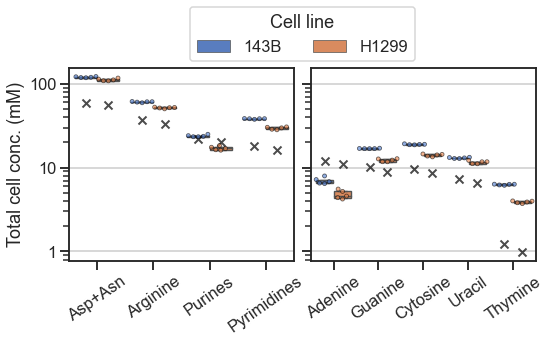

In [15]:
### Add the predictions to above plot ###
# Create plot grid:
fig = plt.figure(figsize=(8, 5))
gs = GridSpec(8, 8)
ax1 = fig.add_subplot(gs[1:8,0:4])
ax2 = fig.add_subplot(gs[1:8,4:8], sharey=ax1)
ax3 = fig.add_subplot(gs[0,2:6])

# Plot the major Asp fates:
inclusion_list = {'Asp+Asn', 'Arginine', 'Purines', 'Pyrimidines'}
mask = [v in inclusion_list for v in df_flat_pred['Asp fate'].values]
# Add prediction, as a single cross:
one_rep_mask = (df_flat_pred['well'] == 1)
g1 = sns.swarmplot(ax=ax1, y='Concentration_pred', x='Asp fate', hue='cell_line', data=df_flat_pred[mask&one_rep_mask], linewidth=2, alpha=0.7, dodge=True, marker='x', palette=['black', 'black'], s=8, legend=False)
# Then add the measured data:
g1 = sns.boxplot(ax=ax1, y='Concentration_mes', x='Asp fate', hue='cell_line', data=df_flat_pred[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g1 = sns.swarmplot(ax=ax1, y='Concentration_mes', x='Asp fate', hue='cell_line', data=df_flat_pred[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g1.grid(True, axis='y')
# g1.set_ylabel('Total cell conc. (μM)');
g1.set_ylabel('Total cell conc. (mM)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=35)
g1.set_yscale('log')

# Plot individual nucleobases:
inclusion_list = {'Adenine', 'Guanine', 'Uracil', 'Thymine', 'Cytosine'}
mask = [v in inclusion_list for v in df_flat_pred['Asp fate'].values]
# Add prediction, as a single cross:
one_rep_mask = (df_flat_pred['well'] == 1)
g2 = sns.swarmplot(ax=ax2, y='Concentration_pred', x='Asp fate', hue='cell_line', data=df_flat_pred[mask&one_rep_mask], linewidth=2, alpha=0.7, dodge=True, marker='x', palette=['black', 'black'], s=8, legend=False)
# Then add the measured data:
g2 = sns.boxplot(ax=ax2, y='Concentration_mes', x='Asp fate', hue='cell_line', data=df_flat_pred[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g2 = sns.swarmplot(ax=ax2, y='Concentration_mes', x='Asp fate', hue='cell_line', data=df_flat_pred[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g2.grid(True, axis='y')
g2.set_yscale('log')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=35);
for tk in g2.get_yticklabels():
    tk.set_visible(False)

# Drop scientific notation on numbers:
g1.yaxis.set_major_formatter(tck.FormatStrFormatter('%g'))
g1.yaxis.set_minor_formatter(tck.LogFormatter())

# Add legend above:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['143B', 'H1299']
title = 'Cell line'
g2.legend_.remove()
ax3.axis('off')
ax3.legend(handles, labels, title=title, bbox_to_anchor=(0,0,1,1), loc="lower left", mode="expand", borderaxespad=0, ncol=2);

# Spacing and print:
fig.tight_layout()
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig('output/Asp-fates_w_predictions.pdf')